# Exercise 07 CNN & Transfer Learning - Assignment

<span style="color:red">**The submission deadline of this assignment is 15/04/2024 23:59.**</span>

<span style="color:red">**Do not submit the saved `.pth` file of the trained CNN, because the file size is too big.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class image classifier with pre-trained Squeeze Net using transfer learning.

The problem to be solved is to classify grayscale images into one of the 10 pre-defined classes:

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

|Label|0|1|2|3|4|5|6|7|8|9|
|-|-|-|-|-|-|-|-|-|-|-|
|Class|T-shit/top|Trouser|Pullover|Dress|Coat|Sandal|Shirt|Sneaker|Bag|Ankle boot|

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Load pre-trained model and re-build the classifier
- Train the re-built classifier
- Test and evaluation
- (Optional) Fine-tuning entire CNN

### Import libraries

In [1]:
# [TBC] complete your code here with proper comments
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report

from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

## Task 1. Build the data pipeline

You are required to use the PyTorch built-in Fashion MNIST dataset, consists of 70,000 $28\times28$ grayscale images in 10 classes, with 7,000 images per class. You can find more information about this dataset from the [PyTorch documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) and the [original source](https://github.com/zalandoresearch/fashion-mnist).

To use the Fashion MNIST dataset and the pre-trained Squeeze Net, apart from the pre-processing transformations illustrated in the Instruction notebook, you also need to convert the grayscale image to the RGB image. To do this, you can add an additional transformation `transforms.Grayscale(num_output_channels=3)` to the sequence of transformations you defined.

<span style="color:red">**[TBC]**</span> You need to:
- Define a sequence of transformations to pre-process the images
- Use `torchvision.datasets.FashionMNIST()` to load the dataset
- Divide the dataset into the training, valiation, and test set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [3]:
# [TBC] complete your code here with proper comments

# define transformations required by the pre-trained SqueezeNet model
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Resize images to fit SqueezeNet input
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalization parameters for pre-trained models
])

# load MNIST dataset
train_val_ds = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)
test_ds = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2]
)

In [4]:
# create the train and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [5]:
# display the dimensionality of a batch
for (X, y) in val_dl:
    print('Feature shape:', X.shape)
    print('Label shape:', y.shape)
    break

Feature shape: torch.Size([512, 3, 28, 28])
Label shape: torch.Size([512])


## Task 2. Load Pre-trained model and Re-build the classifier 

<span style="color:red">**[TBC]**</span> You need to:
- Load the pre-trained Squeeze Net
- Replace the `classifier` part
- Freeze the `features` part
- Set up GPU acceleration if it's possible

In [6]:
# [TBC] complete your code here with proper comments
# load pre-trained SqueezeNet 1.1 model
squeezenet = models.squeezenet1_1(pretrained = True)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

In [7]:
# replace the classifier part
squeezenet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(10)
)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

In [8]:
# freeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = False

In [9]:
# set GPU acceleration
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
squeezenet = squeezenet.to(device)

Using cpu device


## Task 3. Train the re-built classifier

<span style="color:red">**[TBC]**</span> You need to:

- Define a `train()` function
    - Embed automatic model saving in the training process
    - <span style="color:red">**Do not submit the saved file as it will be too big.**</span>
- Specify the training hyper-parameters
- Train the network
- Reload the best model after training
- Plot the loss history of the training probess

In [10]:
# [TBC] complete your code here with proper comments
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss, patience_counter = np.inf, 0
    saved_path, start_time = '', datetime.datetime.now()
    histories = {'train_batch': [], 'train_epoch': [], 'val_batch': [], 'val_epoch': []}

    for epoch in range(epochs):
        # train
        model.train()
        train_epoch_loss = 0.0
        for X, y in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            train_batch_loss = loss_fn(model(X), y)
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
            histories['train_batch'].append(train_batch_loss.item())
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for X, y in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y = X.to(device), y.to(device)
                val_batch_loss = loss_fn(model(X), y)
                val_epoch_loss += val_batch_loss.item()
                histories['val_batch'].append(val_batch_loss.item())
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate reduced after epoch {epoch+1}')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss, patience_counter = val_epoch_loss, 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping!')
                break
                
    return histories, saved_path

In [11]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    squeezenet.classifier.parameters(), # only optimize the classifier part
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 15 #because of compuationnal power
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)

In [12]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))

Validation batch: 100%|██████████| 24/24 [00:20<00:00,  1.20it/s]


Epoch 1: train loss = 1.035556, val loss = 0.783829, time consumed = 0:01:36
Model saved after epoch 1


Validation batch: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


Epoch 2: train loss = 0.873465, val loss = 0.718869, time consumed = 0:03:22
Model saved after epoch 2


Validation batch: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


Epoch 3: train loss = 0.846899, val loss = 0.723408, time consumed = 0:05:09


Validation batch: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


Epoch 4: train loss = 0.840175, val loss = 0.734246, time consumed = 0:06:55


Validation batch: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


Epoch 5: train loss = 0.849990, val loss = 0.754631, time consumed = 0:08:38
Learning rate reduced after epoch 5


Validation batch: 100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


Epoch 6: train loss = 0.768477, val loss = 0.648787, time consumed = 0:10:23
Model saved after epoch 6


Validation batch: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


Epoch 7: train loss = 0.717323, val loss = 0.632031, time consumed = 0:12:08
Model saved after epoch 7


Validation batch: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


Epoch 8: train loss = 0.698293, val loss = 0.624511, time consumed = 0:13:46
Model saved after epoch 8


Validation batch: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


Epoch 9: train loss = 0.683418, val loss = 0.625291, time consumed = 0:15:33


Validation batch: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


Epoch 10: train loss = 0.679114, val loss = 0.608918, time consumed = 0:17:16
Model saved after epoch 10


Validation batch: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


Epoch 11: train loss = 0.665445, val loss = 0.607518, time consumed = 0:19:02
Model saved after epoch 11


Validation batch: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


Epoch 12: train loss = 0.662267, val loss = 0.604909, time consumed = 0:20:51
Model saved after epoch 12


Validation batch: 100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


Epoch 13: train loss = 0.658982, val loss = 0.599689, time consumed = 0:22:36
Model saved after epoch 13


Validation batch: 100%|██████████| 24/24 [00:20<00:00,  1.18it/s]


Epoch 14: train loss = 0.652936, val loss = 0.597688, time consumed = 0:24:23
Model saved after epoch 14


Validation batch: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]

Epoch 15: train loss = 0.645361, val loss = 0.597003, time consumed = 0:26:08
Model saved after epoch 15


<All keys matched successfully>

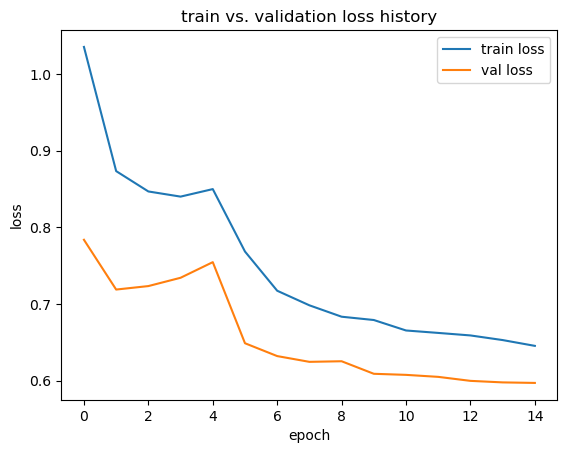

In [13]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Step 4. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [14]:
# [TBC] complete your code here with proper comments
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in tqdm(dataloader, desc = f'Test batch'):
            X, y = X.to(device), y.to(device)
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [18]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred))

Test batch: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


test loss = 0.5986072242259979
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1000
           1       0.95      0.93      0.94      1000
           2       0.65      0.70      0.68      1000
           3       0.72      0.76      0.74      1000
           4       0.62      0.63      0.62      1000
           5       0.88      0.88      0.88      1000
           6       0.53      0.50      0.51      1000
           7       0.87      0.87      0.87      1000
           8       0.91      0.88      0.89      1000
           9       0.91      0.92      0.92      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



## Optional Task. Fine-tuning entire CNN

This task is not mandatory. You need to:
- Unfreeze the `feature extractor`
- Fine-tune the entire netowrk (both the `feature extractor` and the `classifier`) with a relative small learning rate
- Reload the best model after fine-tuning
- Test and evaluation

In [19]:
# [TBC] complete your code here with proper comments
# unfreeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = True

In [22]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-5 # a relative small learning rate
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    squeezenet.parameters(), # optimize the entire network, not only the classifier part
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 5
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)

In [23]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))

Validation batch: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


Epoch 1: train loss = 0.607266, val loss = 0.556209, time consumed = 0:05:34
Model saved after epoch 1


Validation batch: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


Epoch 2: train loss = 0.580817, val loss = 0.535817, time consumed = 0:11:52
Model saved after epoch 2


Validation batch: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


Epoch 3: train loss = 0.562653, val loss = 0.520613, time consumed = 0:18:17
Model saved after epoch 3


Validation batch: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Epoch 4: train loss = 0.550811, val loss = 0.509348, time consumed = 0:24:50
Model saved after epoch 4


Validation batch: 100%|██████████| 24/24 [00:05<00:00,  4.42it/s]

Epoch 5: train loss = 0.542292, val loss = 0.500322, time consumed = 0:28:40
Model saved after epoch 5


<All keys matched successfully>

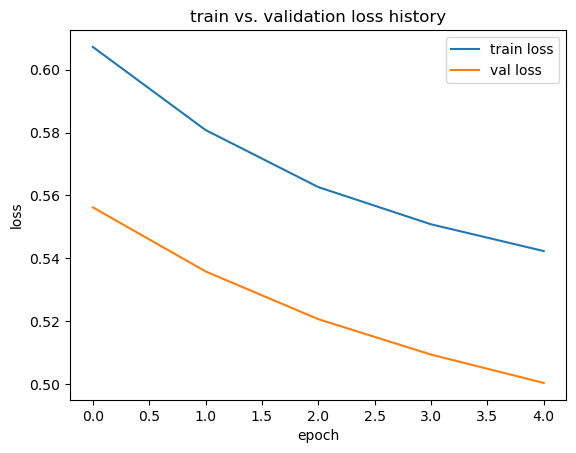

In [24]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred))

Test batch: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


test loss = 0.5045981377363205
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1000
           1       0.97      0.95      0.96      1000
           2       0.74      0.72      0.73      1000
           3       0.75      0.83      0.78      1000
           4       0.68      0.67      0.67      1000
           5       0.91      0.92      0.91      1000
           6       0.55      0.52      0.53      1000
           7       0.89      0.91      0.90      1000
           8       0.93      0.93      0.93      1000
           9       0.94      0.93      0.94      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

